# Ranking sentences by complexity

The app will show the user sentences appropriate for their current vocabulary level. For this, I need to find a way to measure a sentence's complexity for a given user. I can then show each user level-appropriate sentences, which will progressively build in complexity as they grow their vocabulary. Below is my preliminary strategy to achieve this, although it's very much subject to change in the future.

Three complexity scores:

1. Sentence length score: The longer the sentence, the higher the score

2. Word frequency Score: A score incorporating the average frequency of all words in the sentence. I can use the snowball stemmer for each word in the sentence and find the closest match in a frequency list, then I'll take the average frequency of all the words in the phrase to be the word frequency score.

3. Lexical similarity to the target language: This one is the hardest to implement. It will involve using word embeddings such as word2vec to find the n most frequent translations of that word to the user's target language. I will then factor in the frequency score for each of the n translations, as well as their lexical similarity to the translated word and take the highest score to be the lexical similarity score for that word. By combining this score for all the words in a sentence I can calculate its lexical similarity to a target language (how easily a learner who speaks that language could infer the meaning of words in the target language sentence). Since this is a unidirectional process that has to be calculated both ways between any given two languages, it will increase exponentially. For example: 

1 language: 0                                                                           0 i.e 1*0
2 languages: 1->2, 2->1                                                                 2 i.e. 2*1
3 languages: 1->2, 1->3, 2->1, 2->3, 3->1, 3->2                                         6 i.e 3*2
4 languages: 1->2, 1->3, 1->4, 2->1, 2->3, 2->4, 3->1, 3->2, 3->4, 4->1, 4->2, 4->3     12 i.e 4*3

So the number of mappings for n languages is calculated by n*n-1 i.e the number of mappings increases quadratically as a function of n, which is bad. To begin with I'll only calculate the scores from each target language to english as the app will be for english speakers.

I can then create an overall complexity score by taking the weighted sum of all three and choosing the weights based on my subjective interpretation of their effectiveness. My initial guess is that sentence length will be the least useful. Although longer sentences are more likely to contain a couple of uncommon words, if they are surrounded by lots of commonly used words then the average for the whole sentence should be brought down, and a long sentence full of commonly used word is much more useful to a beginner learner than a short but indecipherable one. An illustrative example of this can be found in a line from Hamlet: "Thou wretched, rash, intruding fool, farewell!". Short, yes, but certainly not beginner-friendly.

However, it may be more difficult to find a balance between lexical similarity and word frequency. Many infrequently used words from academia and science share significant lexical similarity across languages, and often it is only the suffix that will be changed. Take this french sentence as an example: "La biodiversité, c'est la richesse de la vie sur Terre, avec ses millions d'espèces, de gènes et d'écosystèmes." Notice how the infrequently used scientific terms are far more lexically similar to their english equivalent than the more common words: espèces (species), gènes, écosystèmes, biodiversité versus vie (life), sur (on) and terre (earth).

It's hard to argue that a beginner french learner will find more use for 'gènes' than 'vie' in daily life, so it is my thinking that word frequency should be more highly weighted than lexical similarity, as the goal is to increase the user's workable vocabulary as quickly as possible without completely discouraging them with incomprehensible sentences.

# Deciding which sentences to show to a user

Once I've created the complexity scores, I will have to make sure to remove any outliers, then normalise them between say 0 and 1 where the most complex sentence will have a score of 1. I then need to decide which of these sentences to show to a user based on the number of words they know.

Assuming the most literate native speaker of a language has a passive vocabulary Vmax (i.e. 50, 000 words), then the user will have a number of known words in their dictionary somewhere between 0 and Vmax. Since comprehension increases more rapidly at the beginning of the learning journey, there are increasingly diminishing returns to a user's overall comprehension of a language with each new word learned. That means I need to normalise the user's number of known words to between 0 and 1 to correspond with an appropriate complexity score, and apply an inverse exponential function so that this value increases more rapidly at lower values of V, with the rate of increase tending to zero as V approaches Vmax. The exact function I'll apply for this normalisation will probably need to be found through trial and error.

Although it's fairly meaningless to choose the activation function to normalize V without also knowing how the complexity scores are distributed, I imagine it will look something like a modified version of the sigmoid function. I.e:

f(v) = -1 + 2/(1 + e^(-kv)), where v is the number of words the user knows, and k is a coefficient that stretches the function horizontally.

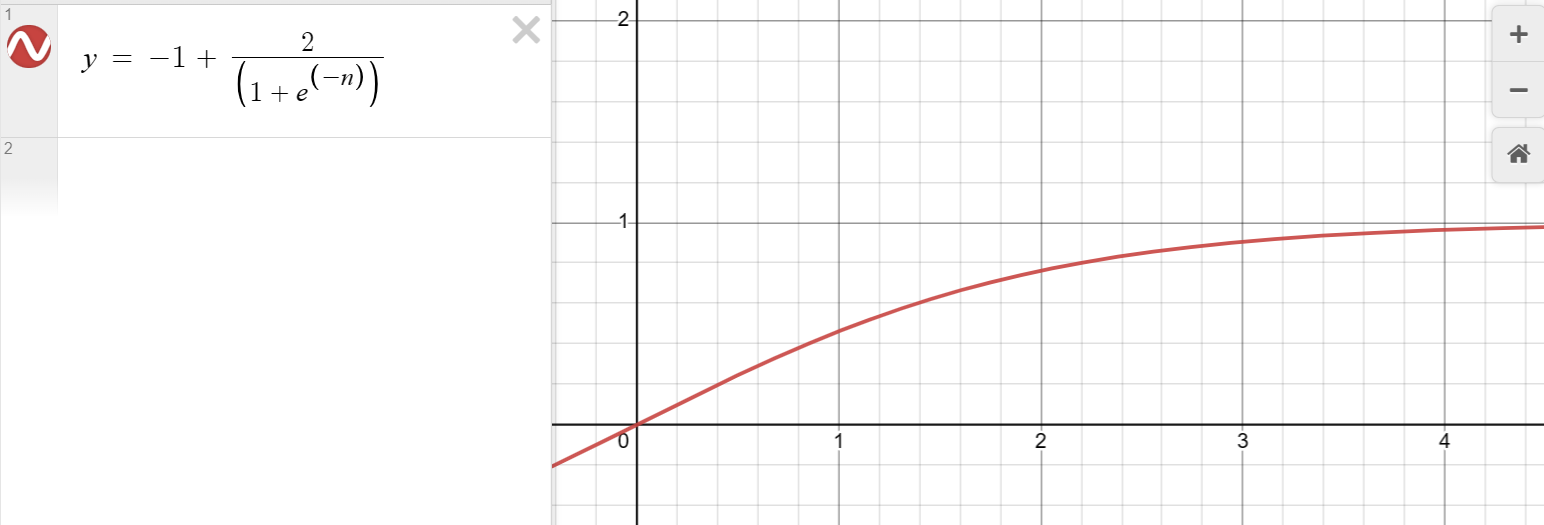

For positive v, the value of f(v) quickly increases from zero at v=0, and the rate of increase of f(v) decreases as v increases. This can be modified as necessary. If we want the value of f(v) to reach 0.5 when the number of known words is 1000, just solve:

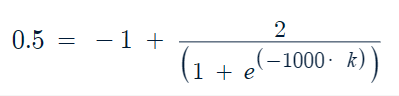

which gives k = ln(3)/1000

Once a the user's passive vocabulary has been normalised, I'll then be able to show them sentences with a complexity score within a given range of their f(v).

I'll also need to account for the number of words the user already knows in a sentence (For example, maybe sentences should to contain between 60% and 80% known words to allow the user to infer from context, although I have no evidence to back this up).

In [ ]:
import os
import re
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from nltk.stem.snowball import SnowballStemmer
%matplotlib inline


In [ ]:
filepath = os.path.join("..", "fra_mixed_2009_1M", "french_sentences_cleaned.csv")
df = pd.read_csv(filepath, delimiter='\t', index_col='id')


In [ ]:
df.head()

# Complexity Score 1: Rank by sentence length

There are two ways to rank sentences by length: Number of characters and number of words. Let's start with the number of characters.

In [ ]:
# Create new column
df['num_characters'] = df['sentence'].str.len()

In [ ]:
print(df.head())

min_characters: int = df["num_characters"].min()
max_characters: int = df["num_characters"].max()

# If there are multiple sentences with max or min number of characters, print the first as an example
print(f'''
    The shortest sentence has {min_characters} characters: {df[df["num_characters"] == min_characters]["sentence"].values[0]}
    The longest sentence has {max_characters} characters: {df[df["num_characters"] == max_characters]["sentence"].values[0]}
    ''')